In [8]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label


In [159]:
!pip install imbalanced-learn


In [10]:
import os
import pandas as pd

BASE_DIR = r"E:\Cources-third semester\Computer vision\skin_lesion_classification"
METADATA_PATH = os.path.join(BASE_DIR, "HAM10000_metadata.csv")

print("Folder exists:", os.path.isdir(BASE_DIR))
print("Metadata exists:", os.path.exists(METADATA_PATH))

df = pd.read_csv(METADATA_PATH)
print(df.head())


Folder exists: True
Metadata exists: True
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [11]:
import os
import pandas as pd

# Set folder paths here.
IMAGE_DIR_1 = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1"
IMAGE_DIR_2 = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_2"
METADATA_PATH = r"E:\Cources-third semester\Computer vision\skin_lesion_classification\HAM10000_metadata.csv"


# Read metadata
df = pd.read_csv(METADATA_PATH)

# sanity checks (very important for the next steps)
required_cols = {"image_id", "dx", "lesion_id"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in metadata: {missing}")

# Creating a complete image path
def resolve_path(image_id: str) -> str:
    filename = image_id + ".jpg"
    path1 = os.path.join(IMAGE_DIR_1, filename)
    path2 = os.path.join(IMAGE_DIR_2, filename)
    if os.path.exists(path1):
        return path1
    if os.path.exists(path2):
        return path2
    return None  # not found

df["img_path"] = df["image_id"].apply(resolve_path)

# Only two classes required for the project
df_binary = df[df["dx"].isin(["mel", "nv"])].copy()

# Drop rows with missing image files 
before = len(df_binary)
df_binary = df_binary.dropna(subset=["img_path"]).reset_index(drop=True)
after = len(df_binary)
print(f"Dropped {before - after} rows due to missing image files.")

# Convert label to 0/1
df_binary["label"] = df_binary["dx"].map({"nv": 0, "mel": 1}).astype(int)

print(df_binary[["image_id", "lesion_id", "dx", "label", "img_path"]].head())
print("Total images:", len(df_binary))
print("Class counts:\n", df_binary["dx"].value_counts())



Dropped 0 rows due to missing image files.
       image_id    lesion_id   dx  label  \
0  ISIC_0024698  HAM_0001751   nv      0   
1  ISIC_0024693  HAM_0000559   nv      0   
2  ISIC_0025964  HAM_0000871  mel      1   
3  ISIC_0030623  HAM_0000871  mel      1   
4  ISIC_0027190  HAM_0000040  mel      1   

                                            img_path  
0  G:\My Drive\datasets\HAM10000\HAM10000_images_...  
1  G:\My Drive\datasets\HAM10000\HAM10000_images_...  
2  G:\My Drive\datasets\HAM10000\HAM10000_images_...  
3  G:\My Drive\datasets\HAM10000\HAM10000_images_...  
4  G:\My Drive\datasets\HAM10000\HAM10000_images_...  
Total images: 7818
Class counts:
 dx
nv     6705
mel    1113
Name: count, dtype: int64


In [12]:
def remove_hairs_strong(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (19, 19))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    mask = cv2.adaptiveThreshold(
        blackhat, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        15, -5
    )

    mask = cv2.medianBlur(mask, 5)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.dilate(mask, dilate_kernel, iterations=1)

    clean_img = cv2.inpaint(img_bgr, mask, 7, cv2.INPAINT_TELEA)
    return clean_img, mask


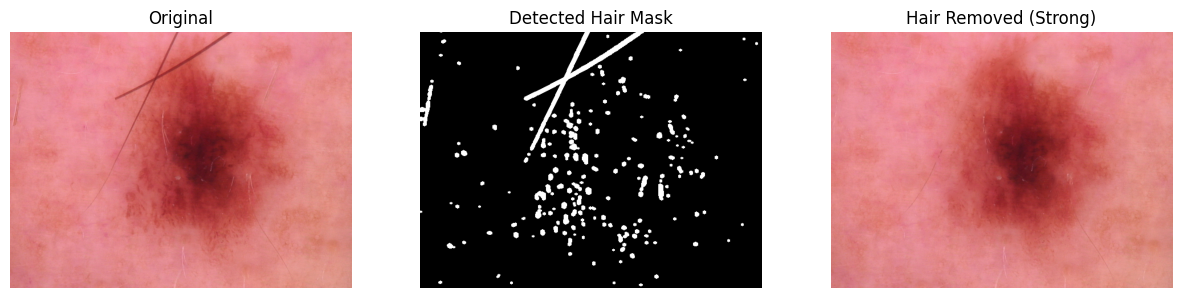

In [14]:
# 1) Load one sample image first
test_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0024306.jpg"

img_bgr = cv2.imread(test_path)

# Hair removal works on BGR
clean_bgr, hair_mask = remove_hairs_strong(img_bgr)

# Convert only for visualization
img_rgb   = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
clean_rgb = cv2.cvtColor(clean_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(hair_mask, cmap="gray")
plt.title("Detected Hair Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(clean_rgb)
plt.title("Hair Removed (Strong)")
plt.axis("off")

plt.show()


In [15]:
import numpy as np

def color_normalization(img_bgr, power=6):
    """
    Shades-of-Gray color constancy.
    Input: BGR image (uint8)
    Output: BGR image (uint8)
    """
    img = img_bgr.astype(np.float32)

    rgb = img.reshape(-1, 3)
    mean = np.power(np.mean(np.power(rgb, power), axis=0), 1 / power)

    norm = mean / np.linalg.norm(mean)
    img_norm = img / norm

    img_norm = np.clip(img_norm, 0, 255).astype(np.uint8)
    return img_norm


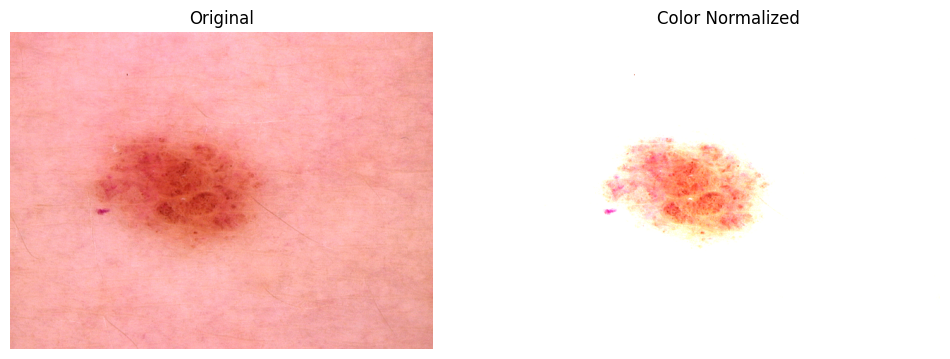

In [16]:
import cv2
import matplotlib.pyplot as plt

img_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0025930.jpg"
img_bgr = cv2.imread(img_path)

norm_img = color_normalization(img_bgr)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB))
plt.title("Color Normalized")
plt.axis("off")

plt.show()


In [17]:
import cv2
import numpy as np

def clean_mask(mask):
    """
    - Largest connected component
    - Closing + blur
    - Ensure binary 0/255
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels <= 1:
        return mask

    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    clean = np.where(labels == largest, 255, 0).astype("uint8")

    kernel = np.ones((7, 7), np.uint8)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=2)
    clean = cv2.GaussianBlur(clean, (7, 7), 0)
    clean = np.where(clean > 128, 255, 0).astype("uint8")
    return clean


def segment_lesion(img_bgr, size=256, k=3, use_otsu=True, random_state=42):
    """
    Input: BGR image
    Output:
      - img_small (BGR resized)
      - segmented (BGR-like after kmeans centroids)
      - final_mask (0/255 uint8)
    """
    img_small = cv2.resize(img_bgr, (size, size), interpolation=cv2.INTER_AREA)

    Z = img_small.reshape((-1, 3)).astype(np.float32)

    # Make k-means deterministic/reproducible
    cv2.setRNGSeed(random_state)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, centers = cv2.kmeans(
        Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
    )

    centers = np.uint8(centers)
    segmented = centers[labels.flatten()].reshape(img_small.shape)

    gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)

    if use_otsu:
        # Otsu threshold (stable)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        # percentile threshold (if this matched your old best)
        thresh_val = np.percentile(gray, 40)
        _, mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)

    # basic morphology cleanup
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    final_mask = clean_mask(mask)
    return img_small, segmented, final_mask


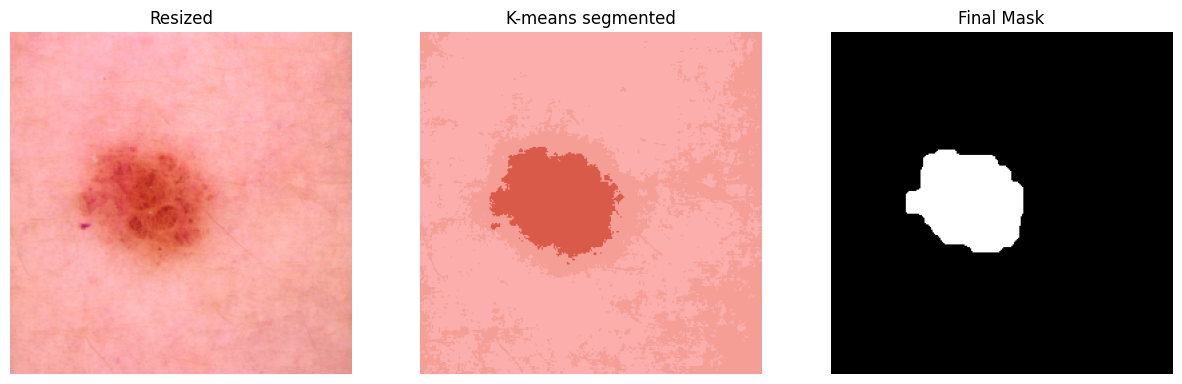

In [18]:
import matplotlib.pyplot as plt

img_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0025930.jpg"
img_bgr = cv2.imread(img_path)

img_small, segmented, mask = segment_lesion(img_bgr, use_otsu=True)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)); plt.title("Resized"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)); plt.title("K-means segmented"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(mask, cmap="gray"); plt.title("Final Mask"); plt.axis("off")
plt.show()


In [19]:
import cv2
import numpy as np

def preprocess(img_bgr, mask, out_size=256, margin=20):
    ys, xs = np.where(mask > 0)

    if len(xs) == 0:
        crop = img_bgr
    else:
        y_min, y_max = int(ys.min()), int(ys.max())
        x_min, x_max = int(xs.min()), int(xs.max())

        h, w = img_bgr.shape[:2]

        y_min = max(0, y_min - margin)
        x_min = max(0, x_min - margin)
        y_max = min(h - 1, y_max + margin)
        x_max = min(w - 1, x_max + margin)

        crop = img_bgr[y_min:y_max+1, x_min:x_max+1]  # +1 for including max

    crop = cv2.resize(crop, (out_size, out_size), interpolation=cv2.INTER_AREA)

    # Light CLAHE (weaker)
    lab = cv2.cvtColor(crop, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    crop = cv2.merge((cl, a, b))
    crop = cv2.cvtColor(crop, cv2.COLOR_LAB2BGR)

    # Light blur
    crop = cv2.GaussianBlur(crop, (3, 3), 0)

    return crop


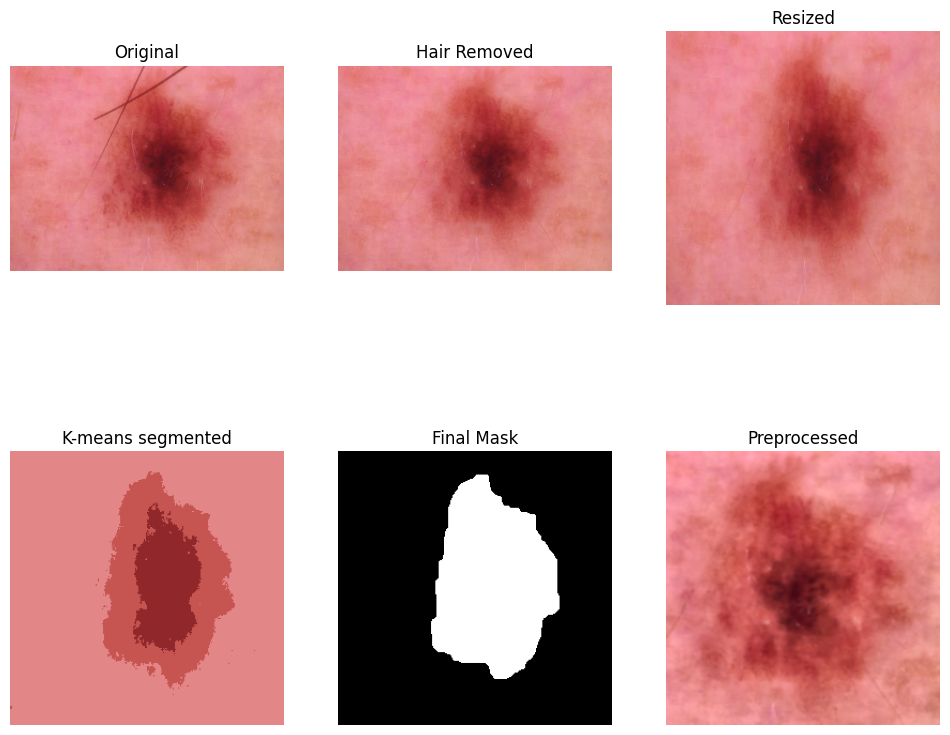

In [20]:
import cv2
import matplotlib.pyplot as plt

img_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0024306.jpg"
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError("Image NOT FOUND!")

# 1) Hair removal
clean_bgr, hair_mask = remove_hairs_strong(img_bgr)

# 2) (Optional but recommended for color consistency) Color normalization
# clean_bgr = color_normalization(clean_bgr)

# 3) Segmentation on resized image (from our unified function)
img_small, segmented, mask = segment_lesion(clean_bgr, use_otsu=True, random_state=42)

# 4) Preprocess must use img_small (as you noted)
pre = preprocess(img_small, mask)

plt.figure(figsize=(12,10))

plt.subplot(2,3,1); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(cv2.cvtColor(clean_bgr, cv2.COLOR_BGR2RGB)); plt.title("Hair Removed"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)); plt.title("Resized"); plt.axis("off")

plt.subplot(2,3,4); plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)); plt.title("K-means segmented"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(mask, cmap="gray"); plt.title("Final Mask"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB)); plt.title("Preprocessed"); plt.axis("off")

plt.show()


In [21]:
from skimage.measure import label, regionprops
import numpy as np

def extract_shape(mask):
    mask_bin = (mask > 0).astype(np.uint8)

    lbl = label(mask_bin)
    regions = regionprops(lbl)

    if not regions:
        return [0.0]*8

    r = max(regions, key=lambda x: x.area)

    return [
        float(r.area),
        float(r.perimeter),
        float(r.eccentricity),
        float(r.solidity),
        float(r.extent),
        float(r.major_axis_length),
        float(r.minor_axis_length),
        float(r.orientation)
    ]


In [22]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_shape_features(img_bgr, mask, shape_features):
    area, perimeter, ecc, sol, ext, maj, minor, ori = shape_features

    mask_bin = (mask > 0).astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_contour = img_bgr.copy()
    cv2.drawContours(img_contour, contours, -1, (0,255,0), 2)  # BGR green

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(mask_bin, cmap="gray")
    plt.title("Lesion Mask")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
    plt.title("Lesion with Contour")
    plt.axis("off")

    print("\n--- Shape Features ---")
    print(f"Area: {area}")
    print(f"Perimeter: {perimeter}")
    print(f"Eccentricity: {ecc}")
    print(f"Solidity: {sol}")
    print(f"Extent: {ext}")
    print(f"Major Axis: {maj}")
    print(f"Minor Axis: {minor}")
    print(f"Orientation: {ori}")

    plt.show()



--- Shape Features ---
Area: 15853.0
Perimeter: 540.3330444827409
Eccentricity: 0.7697844339509119
Solidity: 0.9282702892610376
Extent: 0.6916666666666667
Major Axis: 180.83543924460994
Minor Axis: 115.4279741302661
Orientation: 0.04339563199411198


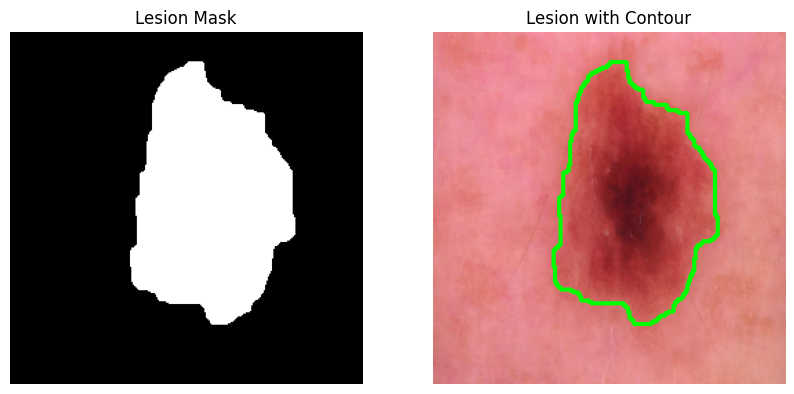

In [23]:
img_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0024306.jpg"
img_bgr = cv2.imread(img_path)

clean_bgr, _ = remove_hairs_strong(img_bgr)
# clean_bgr = color_normalization(clean_bgr)  # If we enable it in the final pipeline

img_small, segmented, mask = segment_lesion(clean_bgr, use_otsu=True, random_state=42)

shape_features = extract_shape(mask)

# debug-only
visualize_shape_features(img_small, mask, shape_features)


In [25]:
import numpy as np

def extract_color(img_small_bgr, mask):
    mask_bool = mask > 0
    lesion_pixels = img_small_bgr[mask_bool]

    if lesion_pixels.size == 0:
        return [0.0] * 15

    b = lesion_pixels[:, 0].astype(np.float32)
    g = lesion_pixels[:, 1].astype(np.float32)
    r = lesion_pixels[:, 2].astype(np.float32)

    feats = [
        r.mean(), g.mean(), b.mean(),
        r.std(),  g.std(),  b.std(),

        np.percentile(r, 90), np.percentile(g, 90), np.percentile(b, 90),
        np.percentile(r, 10), np.percentile(g, 10), np.percentile(b, 10),

        r.var(), g.var(), b.var()
    ]
    return [float(x) for x in feats]


Color features: [177.10047912597656, 67.66050720214844, 66.69589233398438, 32.066341400146484, 25.624841690063477, 22.048978805541992, 209.0, 101.0, 97.0, 124.0, 30.0, 34.0, 1028.250244140625, 656.6325073242188, 486.1575012207031]


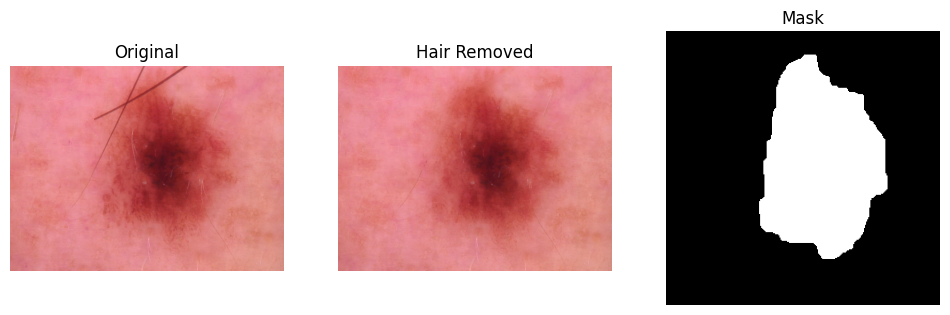

In [26]:
import cv2
import matplotlib.pyplot as plt

img_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0024306.jpg"
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError("IMAGE NOT FOUND! Check the path.")

clean_bgr, hair_mask = remove_hairs_strong(img_bgr)
# clean_bgr = color_normalization(clean_bgr)  

img_small, segmented, mask = segment_lesion(clean_bgr, use_otsu=True, random_state=42)

color_feats = extract_color(img_small, mask)
print("Color features:", color_feats)

# Visualize (optional)
plt.figure(figsize=(12,6))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(clean_bgr, cv2.COLOR_BGR2RGB)); plt.title("Hair Removed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
plt.show()


In [27]:
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

def extract_texture(img_bgr, mask, P=8, R=1):
    # Ensure sizes
    img = cv2.resize(img_bgr, (256, 256), interpolation=cv2.INTER_AREA)
    m = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

    m_bin = (m > 0).astype(np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- ROI crop to reduce background bias in GLCM ---
    ys, xs = np.where(m_bin > 0)
    if len(xs) == 0:
        return [0.0] * (4 + 10)

    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    roi = gray[y0:y1+1, x0:x1+1]
    roi_mask = m_bin[y0:y1+1, x0:x1+1]

    # Keep only lesion region for texture computation:
    roi_lesion = roi.copy()
    roi_lesion[roi_mask == 0] = 0

    # --- Quantize for stable GLCM (reduce levels) ---
    # 16-level quantization is common
    roi_q = (roi_lesion // 16).astype(np.uint8)  # 0..15
    levels = 16

    distances = [1, 2]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(roi_q, distances=distances, angles=angles,
                        levels=levels, symmetric=True, normed=True)

    # Average props over distances & angles
    props = []
    for prop in ["contrast", "homogeneity", "energy", "correlation"]:
        val = graycoprops(glcm, prop).mean()
        props.append(float(val))

    # --- LBP only inside lesion (on full 256x256 is OK) ---
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    lbp_vals = lbp[m_bin > 0]
    if lbp_vals.size == 0:
        hist = np.zeros(10, dtype=np.float32)
    else:
        hist, _ = np.histogram(lbp_vals, bins=10, range=(0, 10), density=True)
        hist = hist.astype(np.float32)

    return props + hist.tolist()


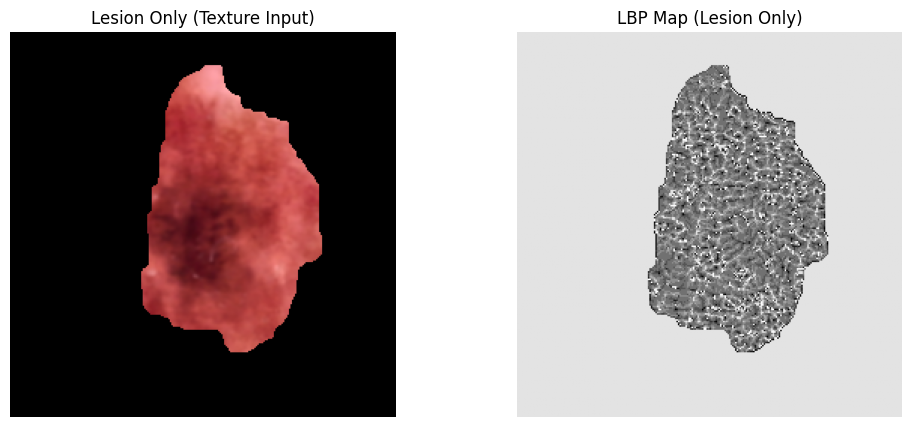

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# pre: preprocessed image (BGR) with size e.g. 256x256
# mask: mask (0/255 or 0/1) which may not be the same size as pre

#1) Pre-size the mask (without blurring)
mask_rs = cv2.resize(mask, (pre.shape[1], pre.shape[0]), interpolation=cv2.INTER_NEAREST)

#2) Make sure the mask is binary and uint8 (0 or 255)
mask_bin = ((mask_rs > 0).astype(np.uint8)) * 255

# 3) Keep only the lesion area (the rest of the pixels will be zero)
lesion = cv2.bitwise_and(pre, pre, mask=mask_bin)

# 4) For LBP it should be grayed out
gray = cv2.cvtColor(lesion, cv2.COLOR_BGR2GRAY)

# 5) LBP calculation
lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")

# 6) Correct display: BGR → RGB
lesion_rgb = cv2.cvtColor(lesion, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(lesion_rgb)
plt.title("Lesion Only (Texture Input)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lbp, cmap="gray")
plt.title("LBP Map (Lesion Only)")
plt.axis("off")

plt.show()


In [29]:
import numpy as np

def extract_features(img_bgr):
    try:
        # 1) Hair removal (BGR)
        clean_bgr, _ = remove_hairs_strong(img_bgr)

        # 2) Segmentation (returns img_small and mask aligned)
        img_small, segmented, mask = segment_lesion(clean_bgr, use_otsu=True, random_state=42)

        # 3) Preprocess for texture (crop/CLAHE/blur)
        pre = preprocess(img_small, mask)

        # 4) Features
        shape = extract_shape(mask)                 # mask-aligned
        color = extract_color(img_small, mask)      # IMPORTANT: use img_small not pre
        texture = extract_texture(pre, mask)        # OK: extract_texture does resize(mask) internally

        feat = np.array(shape + color + texture, dtype=np.float32)
        return feat, True

    except Exception as e:
       
        return None, False


In [30]:
img_path = r"G:\My Drive\datasets\HAM10000\HAM10000_images_part_1\ISIC_0024306.jpg"
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError("IMAGE NOT FOUND")

feat, ok = extract_features(img_bgr)

print("OK:", ok)
print("FEATURE VECTOR length:", len(feat) if ok else None)
print(feat if ok else "No features")


OK: True
FEATURE VECTOR length: 37
[1.5853000e+04 5.4033307e+02 7.6978445e-01 9.2827028e-01 6.9166666e-01
 1.8083543e+02 1.1542797e+02 4.3395631e-02 1.7710048e+02 6.7660507e+01
 6.6695892e+01 3.2066341e+01 2.5624842e+01 2.2048979e+01 2.0900000e+02
 1.0100000e+02 9.7000000e+01 1.2400000e+02 3.0000000e+01 3.4000000e+01
 1.0282502e+03 6.5663251e+02 4.8615750e+02 1.1487885e+00 9.0756017e-01
 3.6265630e-01 9.3925560e-01 5.6140795e-03 2.0059295e-02 2.0059295e-02
 1.5706806e-01 3.5967955e-01 2.5635526e-01 8.1435688e-02 2.9331988e-02
 3.5639942e-02 3.4756828e-02]


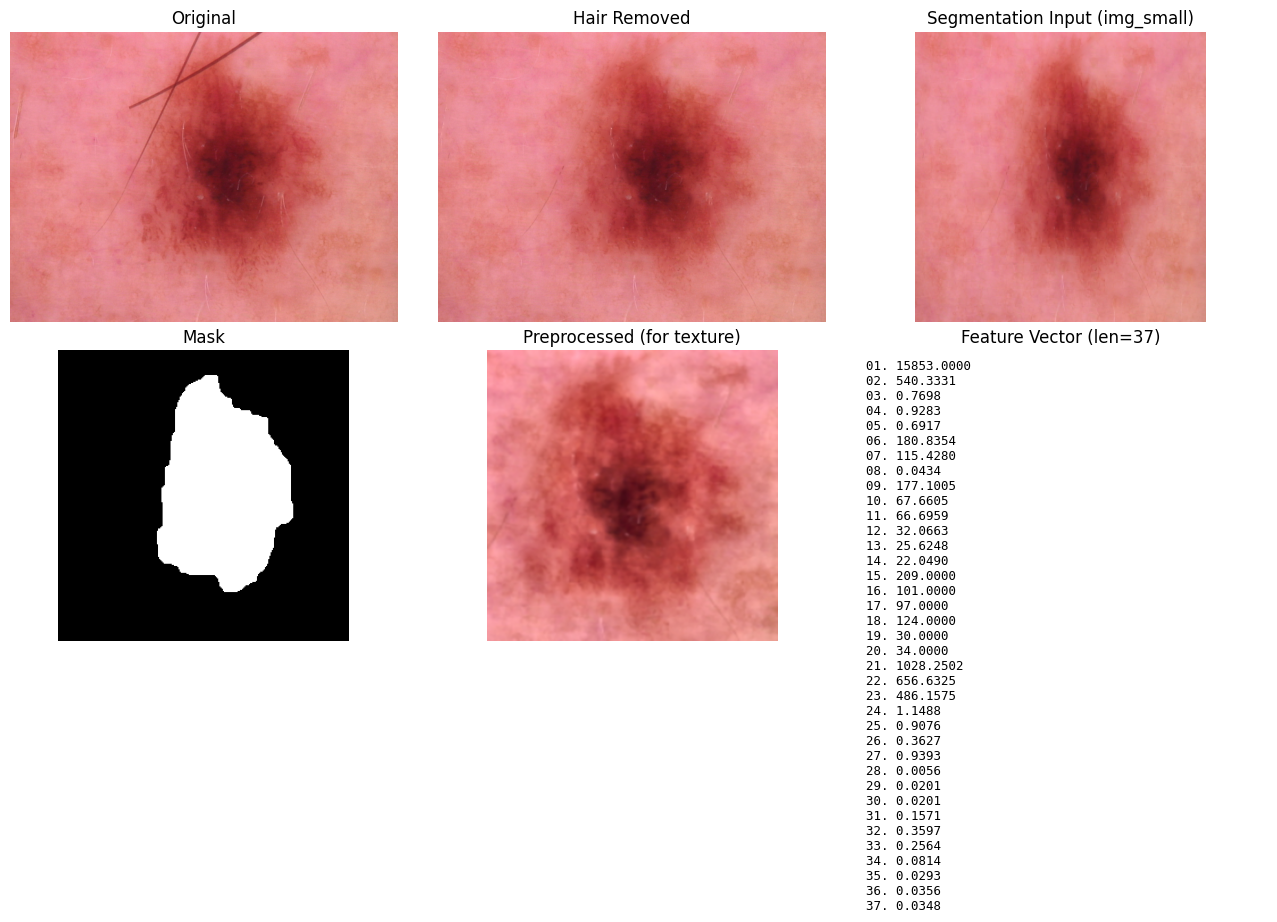

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def to_scalar(x):
    x = np.array(x)
    return float(x.flatten()[0])

# img_bgr should be the same as the output of cv2.imread
# img_bgr = cv2.imread(img_path)

features, success = extract_features(img_bgr)

if not success:
    print("Feature extraction failed on this image.")
else:
    # Rebuilding the same pipeline for display (same input/same decisions)
    clean_bgr, hair_mask = remove_hairs_strong(img_bgr)
    img_small, segmented, mask = segment_lesion(clean_bgr, use_otsu=True, random_state=42)
    pre = preprocess(img_small, mask)

    # ---------- VISUAL DEBUGGING ----------
    plt.figure(figsize=(13, 9))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(clean_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Hair Removed")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB))
    plt.title("Segmentation Input (img_small)")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(pre, cv2.COLOR_BGR2RGB))
    plt.title("Preprocessed (for texture)")
    plt.axis("off")

    # ---------- FEATURE VECTOR DISPLAY ----------
    plt.subplot(2, 3, 6)
    text_lines = [f"{i+1:02d}. {to_scalar(v):.4f}" for i, v in enumerate(features)]
    plt.text(0.03, 0.97, "\n".join(text_lines), fontsize=9, va="top", family="monospace")
    plt.title(f"Feature Vector (len={len(features)})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

def group_train_val_test_split(df, label_col="label", group_col="lesion_id",
                               test_size=0.15, val_size=0.15, random_state=42):
    gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    trainval_idx, test_idx = next(gss1.split(df, df[label_col], groups=df[group_col]))
    df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
    df_test = df.iloc[test_idx].reset_index(drop=True)

    val_ratio_in_trainval = val_size / (1.0 - test_size)
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_ratio_in_trainval, random_state=random_state)
    train_idx, val_idx = next(gss2.split(df_trainval, df_trainval[label_col], groups=df_trainval[group_col]))
    df_train = df_trainval.iloc[train_idx].reset_index(drop=True)
    df_val = df_trainval.iloc[val_idx].reset_index(drop=True)

    return df_train, df_val, df_test

df_train, df_val, df_test = group_train_val_test_split(
    df_binary, label_col="label", group_col="lesion_id",
    test_size=0.15, val_size=0.15, random_state=42
)

print("Train:", len(df_train), " Val:", len(df_val), " Test:", len(df_test))
print("Train class counts:\n", df_train["label"].value_counts())
print("Val class counts:\n", df_val["label"].value_counts())
print("Test class counts:\n", df_test["label"].value_counts())


Train: 5483  Val: 1163  Test: 1172
Train class counts:
 label
0    4723
1     760
Name: count, dtype: int64
Val class counts:
 label
0    980
1    183
Name: count, dtype: int64
Test class counts:
 label
0    1002
1     170
Name: count, dtype: int64


In [34]:
import cv2
from tqdm import tqdm

def build_dataset(df_part, path_col="img_path", label_col="label"):
    X_list = []
    y_list = []
    failed = 0

    for _, row in tqdm(df_part.iterrows(), total=len(df_part)):
        img_path = row[path_col]
        y = int(row[label_col])

        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            failed += 1
            continue

        feat, ok = extract_features(img_bgr)
        if not ok or feat is None:
            failed += 1
            continue

        X_list.append(feat)
        y_list.append(y)

    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int32)

    print(f"Done. X shape={X.shape}, failed={failed}")
    return X, y

X_train, y_train = build_dataset(df_train)
X_val, y_val     = build_dataset(df_val)
X_test, y_test   = build_dataset(df_test)


100%|██████████| 5483/5483 [37:58<00:00,  2.41it/s] 


Done. X shape=(5483, 37), failed=0


100%|██████████| 1163/1163 [08:08<00:00,  2.38it/s]


Done. X shape=(1163, 37), failed=0


100%|██████████| 1172/1172 [08:05<00:00,  2.41it/s]

Done. X shape=(1172, 37), failed=0


In [35]:
print("X_train shape:", X_train.shape)  # The second column should be 37
print("y_train distribution:", np.bincount(y_train))


X_train shape: (5483, 37)
y_train distribution: [4723  760]


In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42))
])

param_grid = {
    "clf__C": [3, 10, 30, 100],
    "clf__gamma": [0.01, 0.03, 0.1, 0.3]
}

gs = GridSearchCV(
    pipe, param_grid=param_grid,
    scoring="f1",  # Suitable for positive class=mel (label=1)
    cv=5, n_jobs=-1, verbose=2
)

gs.fit(X_train, y_train)

best_model = gs.best_estimator_
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__C': 3, 'clf__gamma': 0.01}
Best CV score: 0.5303352842244479


In [42]:
from sklearn.calibration import CalibratedClassifierCV

# Calibration on the entire train (with internal CV)
calibrated_model = CalibratedClassifierCV(
    estimator=best_model,
    method="sigmoid",   # Usually best and most stable for SVM
    cv=5
)

calibrated_model.fit(X_train, y_train)
print("Calibration done.")


Calibration done.


In [43]:
import numpy as np
from sklearn.metrics import fbeta_score, precision_score, recall_score

val_proba = calibrated_model.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.05, 0.95, 37)
best_thr, best_f2 = 0.5, -1

for t in thresholds:
    pred = (val_proba >= t).astype(int)
    f2 = fbeta_score(y_val, pred, beta=2)   
    if f2 > best_f2:
        best_f2 = f2
        best_thr = t

print("Best threshold on VAL:", best_thr)
pred_best = (val_proba >= best_thr).astype(int)
print("VAL F2:", best_f2)
print("VAL Precision:", precision_score(y_val, pred_best))
print("VAL Recall:", recall_score(y_val, pred_best))


Best threshold on VAL: 0.25
VAL F2: 0.6969424460431655
VAL Precision: 0.40789473684210525
VAL Recall: 0.8469945355191257


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score

test_proba = calibrated_model.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= best_thr).astype(int)

print("TEST Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print("\nTEST Report:\n", classification_report(y_test, test_pred, target_names=["nv(0)", "mel(1)"]))

print("TEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("TEST PR-AUC:", average_precision_score(y_test, test_proba))


TEST Confusion Matrix:
 [[775 227]
 [ 32 138]]

TEST Report:
               precision    recall  f1-score   support

       nv(0)       0.96      0.77      0.86      1002
      mel(1)       0.38      0.81      0.52       170

    accuracy                           0.78      1172
   macro avg       0.67      0.79      0.69      1172
weighted avg       0.88      0.78      0.81      1172

TEST ROC-AUC: 0.8891158858753082
TEST PR-AUC: 0.5960282994368443


In [45]:
import joblib
joblib.dump({"model": calibrated_model, "threshold": best_thr}, "svm_skin_lesion_model_calibrated.joblib")
print("Saved: svm_skin_lesion_model_calibrated.joblib")


Saved: svm_skin_lesion_model_calibrated.joblib


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_percent(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_percent,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (%) — Row-normalized")
    plt.show()


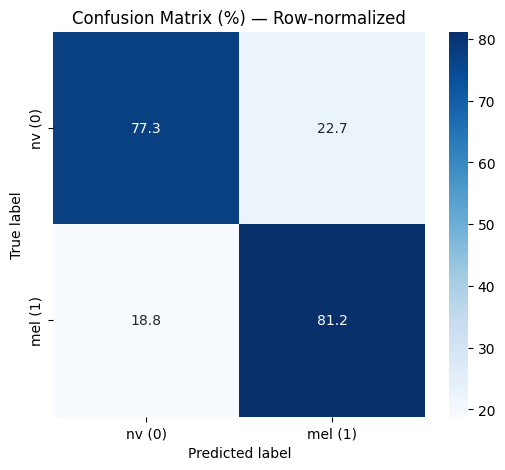

In [47]:
plot_confusion_matrix_percent(
    y_test,
    test_pred,
    class_names=["nv (0)", "mel (1)"]
)


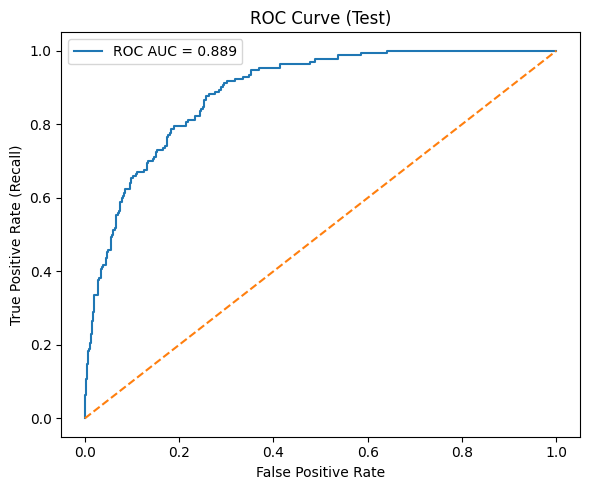

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

test_proba = calibrated_model.predict_proba(X_test)[:, 1]

fpr, tpr, thr = roc_curve(y_test, test_proba)
auc = roc_auc_score(y_test, test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()


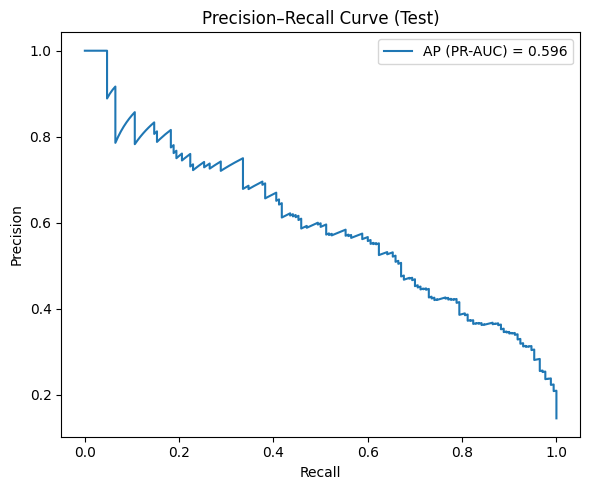

In [49]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thr_pr = precision_recall_curve(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP (PR-AUC) = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()


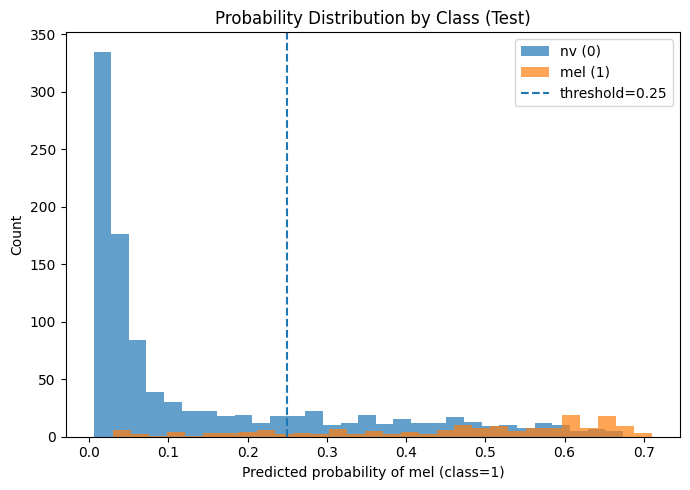

In [50]:
test_proba = calibrated_model.predict_proba(X_test)[:, 1]

p0 = test_proba[y_test == 0]
p1 = test_proba[y_test == 1]

plt.figure(figsize=(7,5))
plt.hist(p0, bins=30, alpha=0.7, label="nv (0)")
plt.hist(p1, bins=30, alpha=0.7, label="mel (1)")
plt.axvline(best_thr, linestyle="--", label=f"threshold={best_thr:.2f}")
plt.xlabel("Predicted probability of mel (class=1)")
plt.ylabel("Count")
plt.title("Probability Distribution by Class (Test)")
plt.legend()
plt.tight_layout()
plt.show()


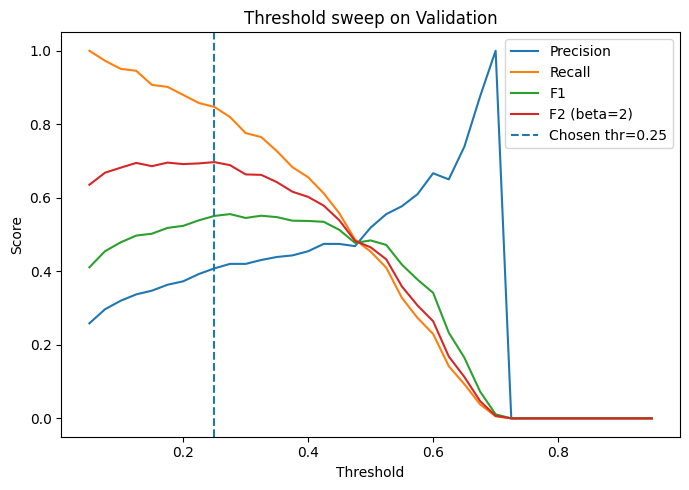

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

def plot_threshold_sweep(y_true, proba, title="Threshold sweep"):
    thresholds = np.linspace(0.05, 0.95, 37)
    P, R, F1, F2 = [], [], [], []

    for t in thresholds:
        pred = (proba >= t).astype(int)
        P.append(precision_score(y_true, pred, zero_division=0))
        R.append(recall_score(y_true, pred, zero_division=0))
        F1.append(f1_score(y_true, pred, zero_division=0))
        F2.append(fbeta_score(y_true, pred, beta=2, zero_division=0))

    plt.figure(figsize=(7,5))
    plt.plot(thresholds, P, label="Precision")
    plt.plot(thresholds, R, label="Recall")
    plt.plot(thresholds, F1, label="F1")
    plt.plot(thresholds, F2, label="F2 (beta=2)")
    plt.axvline(best_thr, linestyle="--", label=f"Chosen thr={best_thr:.2f}")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

val_proba = calibrated_model.predict_proba(X_val)[:, 1]
plot_threshold_sweep(y_val, val_proba, title="Threshold sweep on Validation")


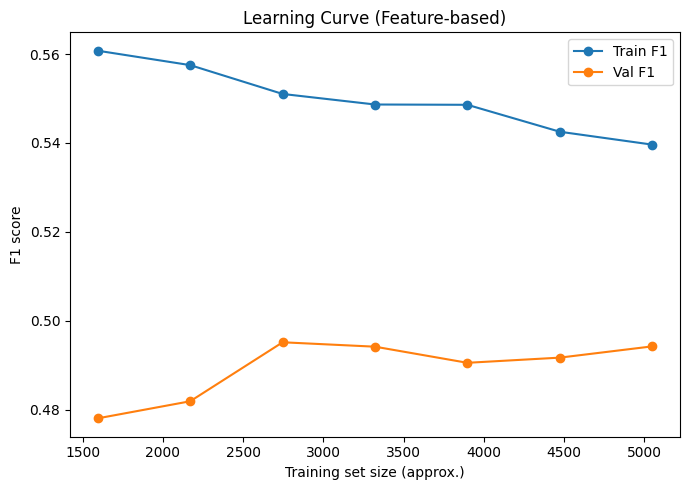

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.base import clone

train_fracs = np.linspace(0.3, 0.95, 7)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

X_all = np.vstack([X_train, X_val])
y_all = np.hstack([y_train, y_val])

sizes = []
train_scores = []
val_scores = []

for frac in train_fracs:
    f1_tr_list, f1_va_list = [], []
    for tr_idx, va_idx in sss.split(X_all, y_all):
        X_tr_full, y_tr_full = X_all[tr_idx], y_all[tr_idx]
        X_va, y_va = X_all[va_idx], y_all[va_idx]

        n = int(len(X_tr_full) * frac)
        X_tr, y_tr = X_tr_full[:n], y_tr_full[:n]

        m = clone(best_model)  # or calibrated_model (but calibrated is two-step)
        m.fit(X_tr, y_tr)

        y_tr_pred = m.predict(X_tr)
        y_va_pred = m.predict(X_va)

        f1_tr_list.append(f1_score(y_tr, y_tr_pred))
        f1_va_list.append(f1_score(y_va, y_va_pred))

    sizes.append(int(len(X_all) * (1-0.2) * frac))
    train_scores.append(np.mean(f1_tr_list))
    val_scores.append(np.mean(f1_va_list))

plt.figure(figsize=(7,5))
plt.plot(sizes, train_scores, marker="o", label="Train F1")
plt.plot(sizes, val_scores, marker="o", label="Val F1")
plt.xlabel("Training set size (approx.)")
plt.ylabel("F1 score")
plt.title("Learning Curve (Feature-based)")
plt.legend()
plt.tight_layout()
plt.show()


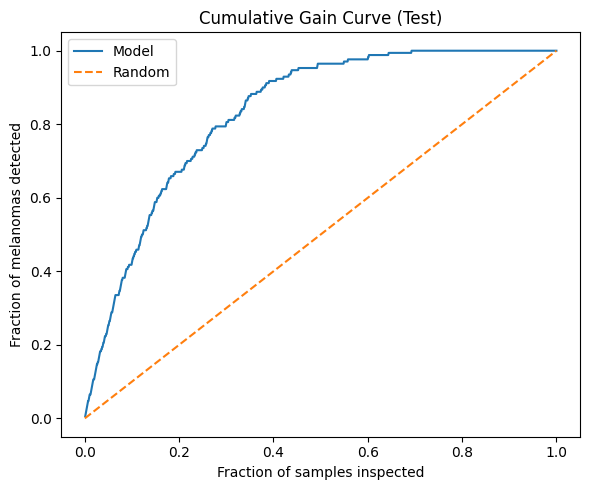

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cumulative_gain(y_true, proba):
    order = np.argsort(proba)[::-1]
    y_sorted = y_true[order]

    cum_mel = np.cumsum(y_sorted)
    total_mel = np.sum(y_true)

    perc_samples = np.arange(1, len(y_true)+1) / len(y_true)
    gain = cum_mel / total_mel

    plt.figure(figsize=(6,5))
    plt.plot(perc_samples, gain, label="Model")
    plt.plot([0,1], [0,1], "--", label="Random")
    plt.xlabel("Fraction of samples inspected")
    plt.ylabel("Fraction of melanomas detected")
    plt.title("Cumulative Gain Curve (Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cumulative_gain(y_test, test_proba)


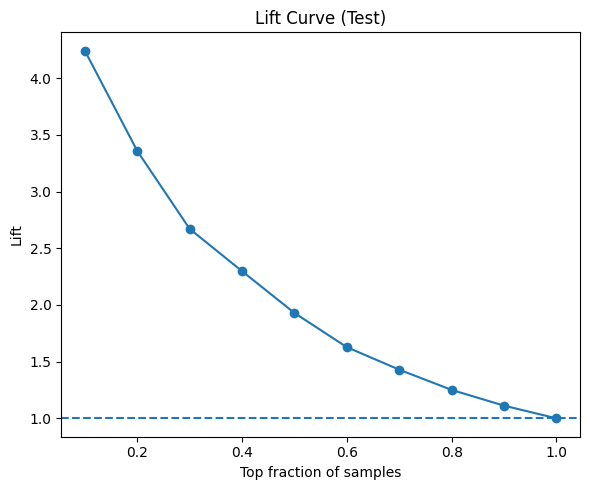

In [55]:
def plot_lift_curve(y_true, proba, bins=10):
    order = np.argsort(proba)[::-1]
    y_sorted = y_true[order]

    lift = []
    for i in range(1, bins+1):
        cut = int(len(y_true) * i / bins)
        lift.append(y_sorted[:cut].mean() / y_true.mean())

    plt.figure(figsize=(6,5))
    plt.plot(np.arange(1, bins+1)/bins, lift, marker="o")
    plt.axhline(1, linestyle="--")
    plt.xlabel("Top fraction of samples")
    plt.ylabel("Lift")
    plt.title("Lift Curve (Test)")
    plt.tight_layout()
    plt.show()

plot_lift_curve(y_test, test_proba)


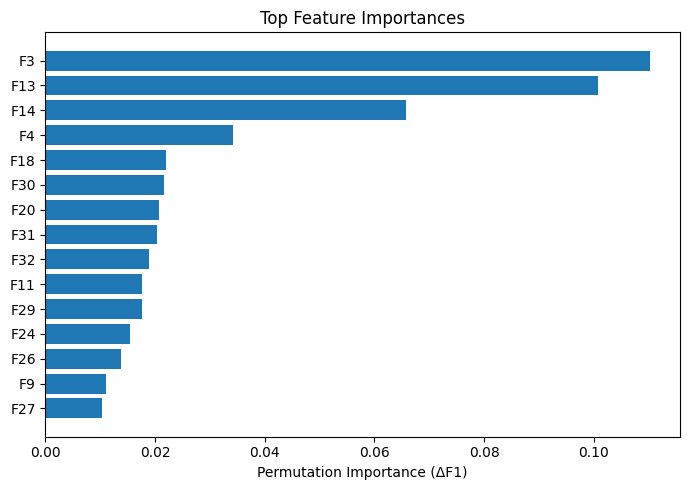

In [56]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    calibrated_model,
    X_test,
    y_test,
    n_repeats=10,
    scoring="f1",
    random_state=42
)

idx = np.argsort(r.importances_mean)[::-1][:15]

plt.figure(figsize=(7,5))
plt.barh(range(len(idx)), r.importances_mean[idx][::-1])
plt.yticks(range(len(idx)), [f"F{i}" for i in idx[::-1]])
plt.xlabel("Permutation Importance (ΔF1)")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


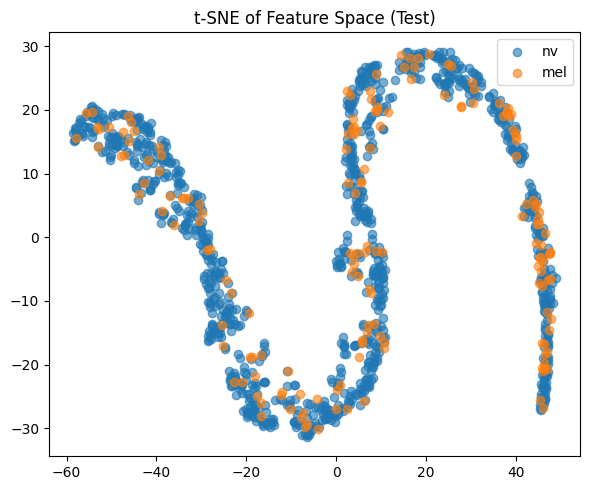

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_emb = tsne.fit_transform(X_test)

plt.figure(figsize=(6,5))
plt.scatter(X_emb[y_test==0,0], X_emb[y_test==0,1], alpha=0.6, label="nv")
plt.scatter(X_emb[y_test==1,0], X_emb[y_test==1,1], alpha=0.6, label="mel")
plt.legend()
plt.title("t-SNE of Feature Space (Test)")
plt.tight_layout()
plt.show()


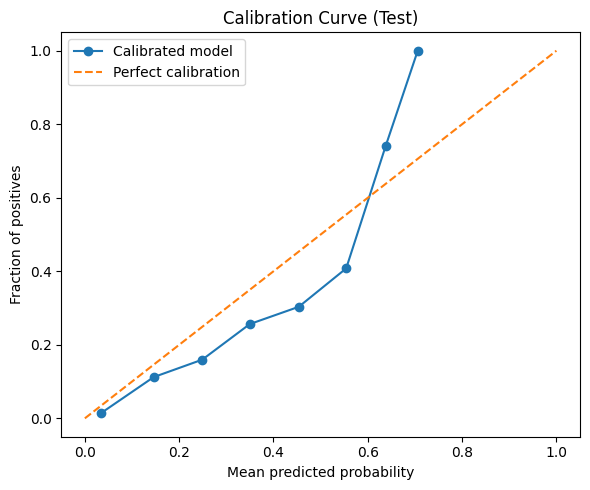

In [58]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated model")
plt.plot([0,1], [0,1], "--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()
